In [319]:
#initialize the dataframe with 1980 data
since_1980_df = pd.DataFrame()
since_1980_df = pd.read_csv('http://wichita.ogs.ou.edu/eq/catalog/1980/1980.csv')

# add additional years
for year in range(1981,2016):
    url = 'http://wichita.ogs.ou.edu/eq/catalog/' + str(year) + '/' + str(year) + '.csv'
    temp_df = pd.read_csv(url)
    # This might not be the most efficient method
    since_1980_df = since_1980_df.append(temp_df)

In [320]:
%matplotlib inline
import numpy as np
import scipy as sp
import json
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from pyquery import PyQuery as pq
import requests
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [321]:
#Add column for year
years = []
for time in since_1980_df['origintime']:
    year = int(str.split(time, '-')[0])
    years.append(year)
    #index = time.key
year_column = pd.Series(years, index=since_1980_df.index)
since_1980_df['year'] = year_column

In [322]:
#Reset index
since_1980_df = since_1980_df.reset_index()

In [323]:
since_1980_df.head()

,index,id,origintime,latitude,longitude,depth,err_lon,err_lat,err_depth,err_origintime,county,origin_src,prefmag,pmag_type,pmag_src,mw,mw_src,mblg_ogs,mblg_usgs,ml_ogs,m3hz_ogs,md_ogs,mb,ms,mfa,max_mmi,reafile,reamtime,geom,pdlid,mw_ogs,year
0,0,255,1980-01-05 07:11:31.21,35.586,-97.894,5,NaN,NaN,NaN,NaN,CANADIAN,OGS,1.9,M3Hz,OGS,NaN,NaN,1.6,NaN,NaN,1.9,1.7,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E6100000F0A7C64B377958C05EBA490C02CB...,NaN,NaN,1980
1,1,256,1980-01-12 07:12:56.45,36.453,-97.642,5,NaN,NaN,NaN,NaN,GARFIELD,OGS,1.7,M3Hz,OGS,NaN,NaN,NaN,NaN,NaN,1.7,1.4,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000000C022B87166958C0448B6CE7FB39...,NaN,NaN,1980
2,2,257,1980-02-03 00:46:30.05,33.994,-97.463,5,NaN,NaN,NaN,NaN,LOVE,OGS,2.2,M3Hz,OGS,NaN,NaN,1.9,NaN,NaN,2.2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000001283C0CAA15D58C0AC1C5A643BFF...,NaN,NaN,1980
3,3,258,1980-02-05 04:32:35.45,34.046,-97.451,5,NaN,NaN,NaN,NaN,LOVE,OGS,2.1,M3Hz,OGS,NaN,NaN,2.3,NaN,NaN,2.1,1.9,NaN,NaN,NaN,3,NaN,NaN,0101000020E6100000BE9F1A2FDD5C58C0D9CEF753E305...,NaN,NaN,1980
4,4,259,1980-03-09 03:57:10.56,35.100,-95.100,5,NaN,NaN,NaN,NaN,HASKELL,OGS,1.2,M3Hz,OGS,NaN,NaN,1.4,NaN,NaN,1.2,1.4,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000006666666666C657C0CDCCCCCCCC8C...,NaN,NaN,1980


In [324]:
def find_regions(df):
    lat = np.arange(int(min(df.latitude))-2, int(max(df.latitude))+2, 0.5)
    long = np.arange(int(min(df.longitude))-2, int(max(df.longitude))+2, 0.5)
    lat_pairs = []
    for i in range(0,len(lat)-1):
        lat_pair = (lat[i], lat[i+1])
        lat_pairs.append(lat_pair)
    long_pairs = []
    for i in range(0,len(long)-1):
        long_pair = (long[i], long[i+1])
        long_pairs.append(long_pair)
    pairs = []
    for lats in lat_pairs:
        for longs in long_pairs:
            pair = lats, longs
            pairs.append(pair)
    return(long, lat, pairs)

In [325]:
#find regions
long_list, lat_list, pairs = find_regions(since_1980_df)

In [326]:
#longs=all longitudes from find_regions
#lats=all latitudes from find_regions
def get_region(long, lat, long_list, lat_list):
    ulong_bool = (long>=long_list)
    llong_bool = (long<=long_list)
    region_long = max(long_list[ulong_bool]), min(long_list[llong_bool])
    
    ulat_bool = (lat>=lat_list)
    llat_bool = (lat<=lat_list)
    region_lat = max(lat_list[ulat_bool]), min(lat_list[llat_bool])
    
    region = region_long, region_lat
    return region

In [327]:
def add_region_col(df):
    regions = []
    for index in df.index:
        region = get_region(df.loc[index, 'longitude'], df.loc[index, 'latitude'], long_list, lat_list)
        regions.append(region)
    Sregions = pd.Series(data=regions, index=df.index)
    df['region'] = Sregions
    return df

In [328]:
since_1980_df=add_region_col(since_1980_df)

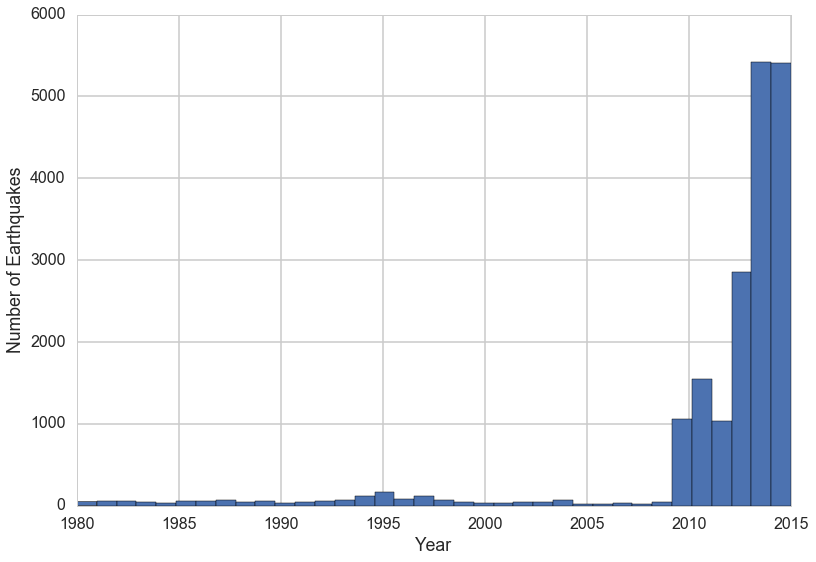

In [329]:
#plot number of earthquakes by year
plt.hist(since_1980_df['year'].values, bins=2015-1980+1)
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')

In [330]:
#DISTANCE FUNCTION
#FOR CALCULATING DISTANCE TO FRACKING SITES, 
#DISTANCE FROM ONE EARTHQUAKE SITE TO THE NEXT, ETC.

#function taken from http://www.johndcook.com/blog/python_longitude_latitude/
#assumes that earth is perfectly spherical
import math

#in kilometers
def distancef(lat1, long1, lat2, long2, earth_radius=6371):
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
    
    distance=earth_radius*arc
 
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return distance

In [331]:
#EXAMPLE OF FUNCTION IN USE
distance = distancef(since_1980_df.loc[5, 'latitude'], 
                     since_1980_df.loc[5, 'longitude'], 
                     since_1980_df.loc[6, 'latitude'], 
                     since_1980_df.loc[6, 'longitude'])
distance

10.293837976092014

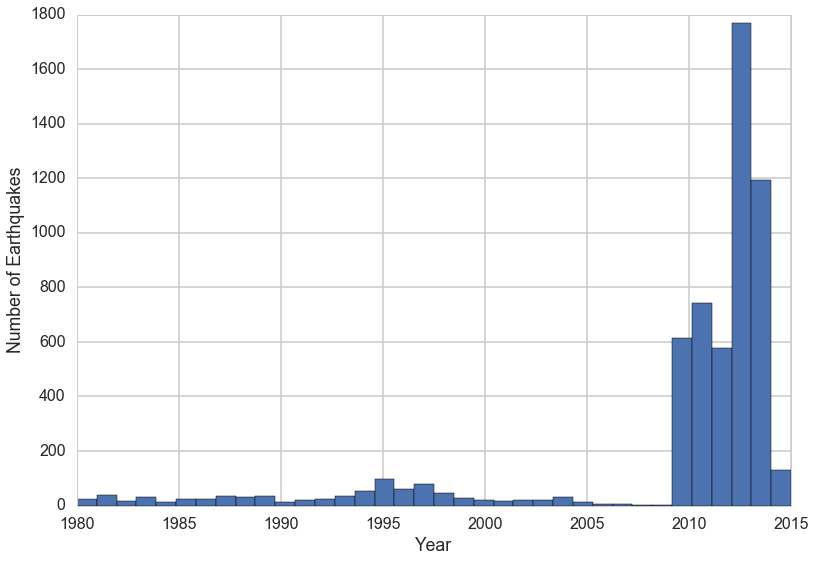

In [332]:
#Earthquakes <2 magnitude
#mask for earthquakes >2 magnitude
l2mask = since_1980_df['prefmag'] <2
plt.hist(since_1980_df[l2mask]['year'].values, bins=2015-1980+1)
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')

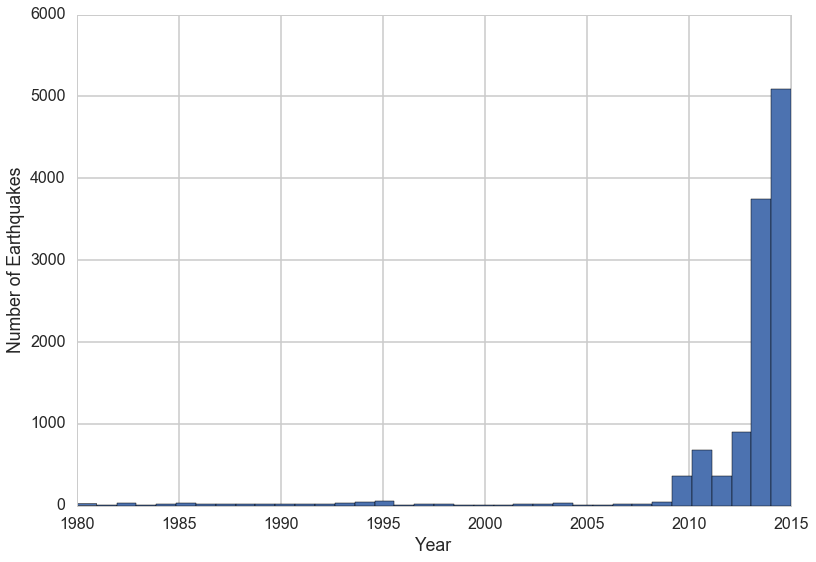

In [333]:
#Earthquakes 2>magnitude<4
#mask for earthquakes >2 magnitude
b24mask = (since_1980_df['prefmag'] >2) & (since_1980_df['prefmag'] < 4)
plt.hist(since_1980_df[b24mask]['year'].values, bins=2015-1980+1)
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')

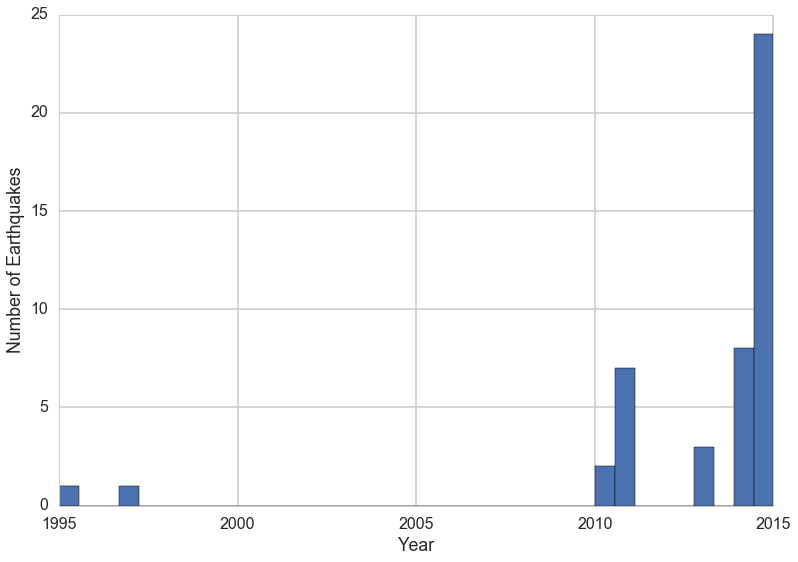

In [334]:
#Earthquakes >4 magnitude
#mask for earthquakes >4 magnitude
gfmask = since_1980_df['prefmag'] >4
plt.hist(since_1980_df[gfmask]['year'].values, bins=2015-1980+1)
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')

In [335]:
#REQUIRES INSTALLATION conda install basemap
#received assistance from https://peak5390.wordpress.com/2012/12/08/matplotlib-basemap-tutorial-plotting-points-on-a-simple-map/
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

def plot_earthquakes(df, minyr, maxyr, cities):
    #mask = df.year>=minyr & df.year<=maxyr
    map = Basemap(llcrnrlon=int(min(df.longitude))-1, llcrnrlat=int(min(df.latitude))-1,
                  urcrnrlon=int(max(df.longitude))+1, urcrnrlat=int(max(df.latitude))+1)
    """
    min_marker_size = 4
    for lon, lat, mag in zip(df.longitude.values, df.latitude.values, df.prefmag.values):
        x,y = map(lon, lat)
        msize = mag * min_marker_size
        map.plot(x, y, 'ro', markersize=msize)
    """
    map.plot(df.longitude.values, df.latitude.values, 'ro', markersize=2)
    map.drawmapboundary(fill_color='white')
    map.drawcoastlines()
    map.drawstates()
    map.drawcounties()
    map.plot(cities.longitude.values, cities.latitude.values, 'bo', markersize=10)
    #for city in zip(cities.longitude.values, cities.latitude.values, cities.city.values)
    #for i in range(0,1):
        #plt.text(cities.longitude.values[i], cities.latitude.values[i], cities.city.values[i])
    #x, y = map(97.6, 35.4)
    #plt.text(x,y, 'Oklahoma City')
    plt.plot()
    plt.show()

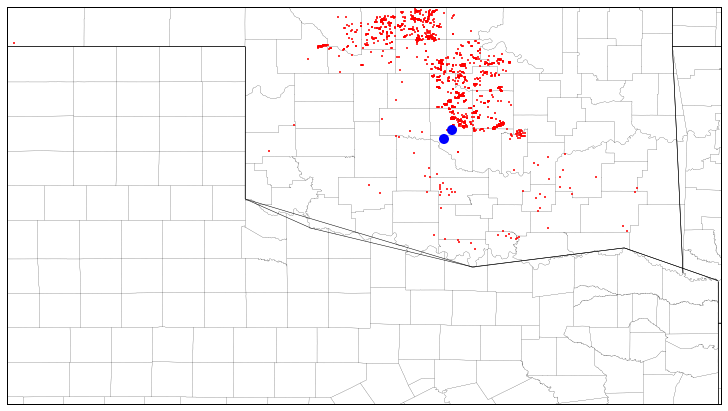

(33.811, -94.466000000000008)

In [336]:
#TESTING
cities = pd.read_csv('tempdata/OK_Lat_Long.csv')
plot_earthquakes(since_1980_df[(since_1980_df.prefmag>=3)],1980,1990, cities)
min(since_1980_df.latitude.values), max(since_1980_df.longitude.values)

In [358]:
import datetime
#function to create list of interarrival times in hours from df 
def get_hours_between(df):
    dates=[]
    origintimes = df.origintime.values
    for date in origintimes:
        year, month, day = date.split('-')
        day, hour = day.split(' ')
        hour, minute, second = hour.split(':')
        if len(second.split('.'))==2:
            second, microsecond = second.split('.')
        elif len(second.split('.'))==1:
            microsecond=0
        dates.append(datetime.datetime(int(year), int(month), int(day), int(hour), int(minute), 
                                       int(second), int(microsecond)))
    dates=sorted(dates)
    deltas=[]
    for i in range(1,len(dates)):
        delta = dates[i] - dates[i-1]
        delta = delta.total_seconds()/3600
        deltas.append(delta)
    deltas = np.array(deltas)
    return deltas

In [383]:
#get interarrival times for whole df
deltas = get_hours_between(since_1980_df[since_1980_df.prefmag>=3])
len(deltas)

1782

In [384]:
#fit and plot exponential to data
def fit_expo(deltas, bins=100, xmax=100, ymax=0.02):
    expo_fit = sp.stats.expon.fit(deltas, floc=0)
    plt.hist(deltas, bins=bins, normed=True)
    x = np.arange(0,3000,0.01)
    y = sp.stats.expon.pdf(x, scale=expo_fit[1])
    plt.plot(x,y)
    plt.xlim([0,xmax])
    plt.ylim([0,ymax])
    return(expo_fit[1])

179.55323994610228

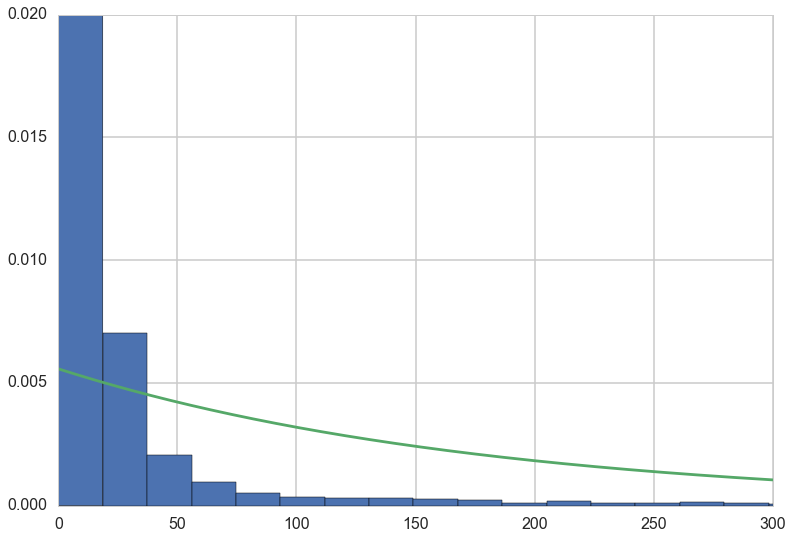

In [385]:
fit = fit_expo(deltas, bins=1000, xmax=300, ymax=0.02) #, bins=1000, xmax=500, ymax=0.04)
fit

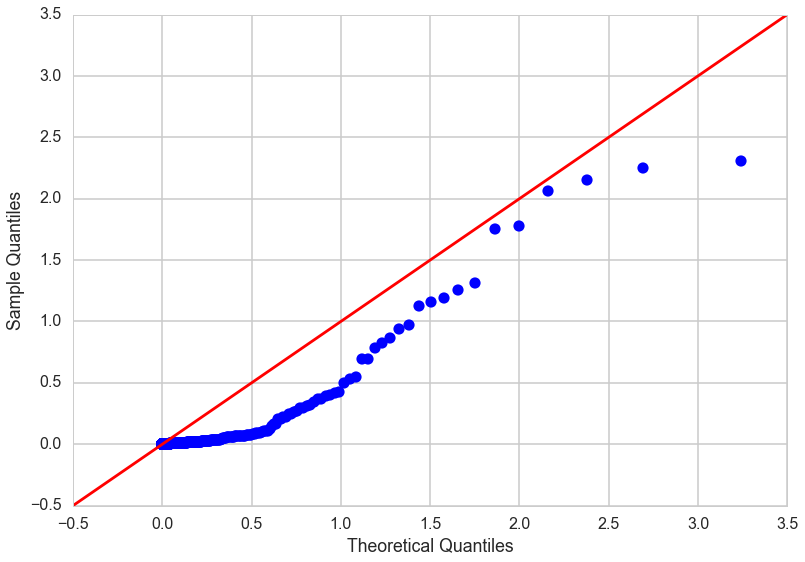

In [389]:
import statsmodels.api as sm
sm.qqplot(deltas, dist='gamma', fit=True, line='45')
plt.show()

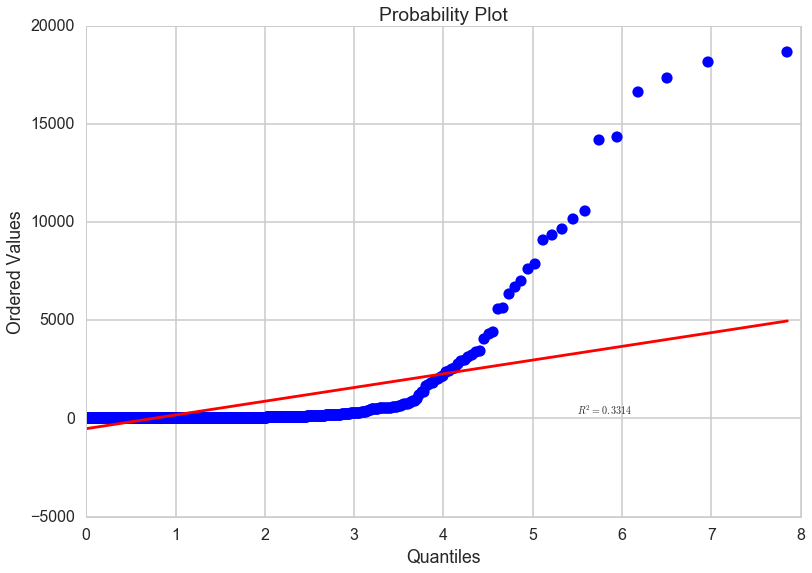

In [391]:
sp.stats.probplot(deltas, dist='expon', plot=plt)
plt.show()

643.04536067522622

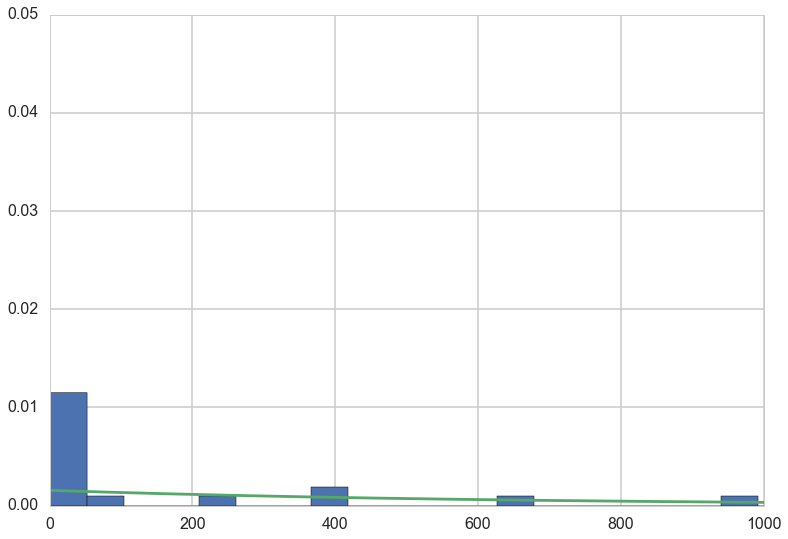

In [374]:
since_1980_df_subset = since_1980_df[(since_1980_df.region==((-98.0, -97.5), (35.5, 36.0))) & (since_1980_df.prefmag>=3)]
deltas2 = get_hours_between(since_1980_df_subset)
coordinates = fit_expo(deltas, bins=100, ymax=0.05, xmax=1000)
coordinates

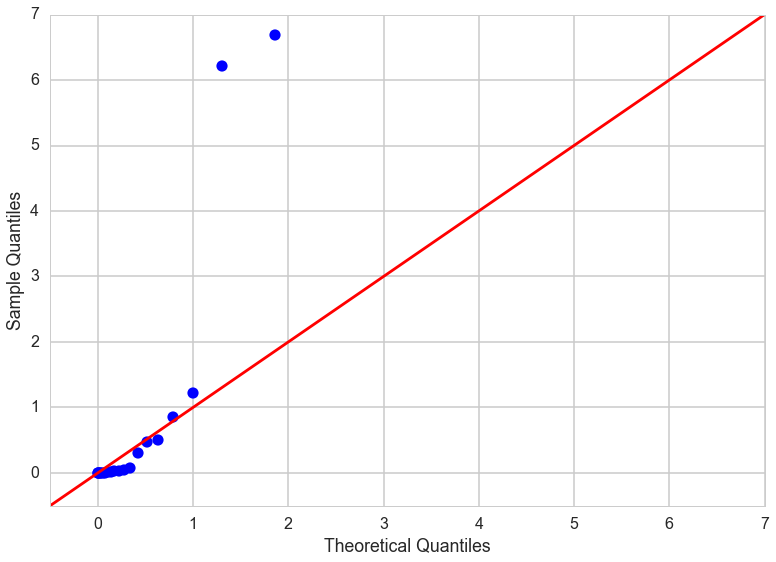

In [375]:
import statsmodels.api as sm
sm.qqplot(deltas2, dist='gamma', fit=True, line='45')
plt.show()

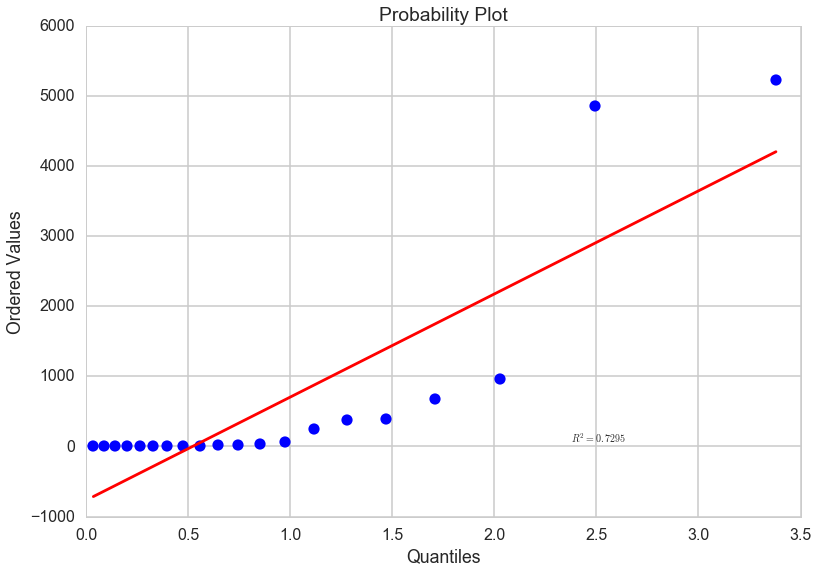

In [376]:
sp.stats.probplot(deltas2, dist='expon', plot=plt)
plt.show()

In [ ]:
#Exponential?
#sp.stats.kstest(deltas, 'expon', alternative='two-sided')

In [ ]:
#USE UNIVERSALITY OF THE UNIFORM (PROBABILITY INTEGRAL TRANSFORM) TO DETERMINE WHETHER THE DISTRIBUTION IS EXPONENTIAL